# H2O.ai XGBoost GPU Benchmarks

In this notebook, we benchmark the latest version of [XGBoost](https://github.com/h2oai/xgboost), the well-known Kaggle-winning gradient boosting algorithm, and in particular, the [XGBoost GPU plugin](https://github.com/h2oai/xgboost/blob/master/plugin/updater_gpu/README.md). We also showcase the integration of XGBoost (incl. the GPU version) into H2O.

In [1]:
## For comparison between 1 GPU and 1 CPU, we use only 1 CPU:
#numactl -C 0 -N 0 -m 0 jupyter notebook

## This will ensure that we only use the first CPU on multi-CPU systems

![1CPU](./1CPUonNUMA.png)

In [2]:
 import os

In [3]:
## First time only: install xgboost and H2O, and restart the kernel afterwards
if False:
    ## Build XGBoost from source and install its Python module
    import os
    os.system("mkdir -p tmp && cd tmp && git clone https://github.com/h2oai/xgboost --recursive && cd xgboost && mkdir build && cd build && cmake .. -DPLUGIN_UPDATER_GPU=ON -DCUB_DIRECTORY=../cub -DCUDA_NVCC_FLAGS=\"--expt-extended-lambda -arch=sm_30\" && make -j; make; cd ../python-package && python3.6 setup.py install")

    ## Download and install H2O and its Python module
    os.system("cd tmp && wget http://h2o-release.s3.amazonaws.com/h2o/rel-vajda/1/h2o-3.10.5.1.zip && unzip h2o-3.10.5.1.zip")
    os.system("python3.6 -m pip install h2o-3.10.5.1/python/h2o-3.10.5.1-py2.py3-none-any.whl --upgrade")
    
    ## restart the kernel!

In [4]:
%matplotlib inline
import xgboost as xgb
import pandas as pd
import numpy as np
import scipy as sp
import os
import time
from sklearn import metrics

In [5]:
path = "../../higgs_head_2M.csv"
if not os.path.exists(path):
    os.system("wget https://s3.amazonaws.com/h2o-public-test-data/bigdata/laptop/higgs_head_2M.csv")
num_class = 2
num_round = 100
learn_rate = 0.02
max_depth = 10

## Parse data into a Pandas Frame
df = pd.read_csv(path, header=None)

In [6]:
df_target = df.iloc[:,0]
df.drop(df.iloc[:,0], axis=1, inplace=True)
cols = df.columns.values
df.shape

(2000000, 27)

In [7]:
train = df

In [8]:
train_target = df_target

In [9]:
print(train.shape)

(2000000, 27)


In [10]:
!lscpu

Architecture:          x86_64
CPU op-mode(s):        32-bit, 64-bit
Byte Order:            Little Endian
CPU(s):                8
On-line CPU(s) list:   0-7
Thread(s) per core:    2
Core(s) per socket:    4
Socket(s):             1
NUMA node(s):          1
Vendor ID:             GenuineIntel
CPU family:            6
Model:                 60
Model name:            Intel(R) Core(TM) i7-4790K CPU @ 4.00GHz
Stepping:              3
CPU MHz:               4401.750
CPU max MHz:           4400,0000
CPU min MHz:           800,0000
BogoMIPS:              8000.46
Virtualization:        VT-x
L1d cache:             32K
L1i cache:             32K
L2 cache:              256K
L3 cache:              8192K
NUMA node0 CPU(s):     0-7
Flags:                 fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush dts acpi mmx fxsr sse sse2 ss ht tm pbe syscall nx pdpe1gb rdtscp lm constant_tsc arch_perfmon pebs bts rep_good nopl xtopology nonstop_tsc cpuid aperfmperf pni pclmulqdq

In [11]:
!cat /proc/meminfo | grep MemTotal

MemTotal:       16254660 kB


In [12]:
!nvidia-smi -L

GPU 0: GeForce GTX 1080 (UUID: GPU-c404bd6a-aebc-01bb-eb71-903138fb44cb)


In [13]:
def runXGBoost(param):
    have_updater = "updater" in param.keys()
    label = "XGBoost " \
        + ("GPU hist" if have_updater and param["updater"]=="grow_gpu_hist" else "GPU exact" if have_updater and param["updater"]=="grow_gpu" else "CPU") \
        + " " + (param["tree_method"] if "updater" not in param.keys() else "")
    print(label)
    print("=====================")
    for k, v in param.items():
        print(k, v)
    print("=====================")
    
    t_start = time.time()
    dtrain = xgb.DMatrix(train.values, label = train_target.values, feature_names=[str(c) for c in cols])
    tt = time.time() - t_start
    print("Time to create DMatrix (sec): ", tt)
    dmatrix_times.append(tt)
    
    t_start = time.time()
    bst = xgb.train(param, dtrain, num_round)
    tt = time.time() - t_start
    print("Time to train (sec): ", tt)
    train_times.append(tt)

    t_start = time.time()
    preds = bst.predict(dtrain)
    tt = time.time() - t_start
    print("Time to predict (sec): ", tt)
    score_times.append(tt)

    labels = dtrain.get_label()
    auc = metrics.roc_auc_score(labels, preds)
    print("Training AUC:", auc)
    valid_aucs.append(auc)
    plot_labels.append(label)
    
    fs = bst.get_fscore()
    
    # Optional: Uncomment to show variable importance
    #varimp = pd.DataFrame({'Importance': list(fs.values()), 'Feature': list(fs.keys())})
    #varimp.sort_values(by = 'Importance', inplace = True, ascending = False)
    #varimp.head(10).plot(label='importance',kind="barh",x="Feature",y="Importance").invert_yaxis()

In [14]:
valid_aucs = []
dmatrix_times = []
train_times = []
score_times = []
plot_labels = []

In [15]:
param = {
    "objective":('reg:logistic' if num_class>1 else 'reg:linear')
    , "max_depth":max_depth
    , "eta":learn_rate
    , "tree_method":"exact"
    , "subsample":0.7
    , "colsample_bytree":0.9
    , "min_child_weight":5
    , "seed":12345
}
runXGBoost(param)

XGBoost CPU exact
objective reg:logistic
max_depth 10
eta 0.02
tree_method exact
subsample 0.7
colsample_bytree 0.9
min_child_weight 5
seed 12345
Time to create DMatrix (sec):  0.3741605281829834
[15:36:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1830 extra nodes, 0 pruned nodes, max_depth=10
[15:36:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1848 extra nodes, 0 pruned nodes, max_depth=10
[15:36:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1956 extra nodes, 0 pruned nodes, max_depth=10
[15:36:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1876 extra nodes, 0 pruned nodes, max_depth=10
[15:36:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1918 extra nodes, 0 pruned nodes, max_depth=10
[15:36:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1874 extra nodes, 0 pruned nodes, max_depth=10
[15:36:23] /workspace/src/tree/updater_prune.cc:

[15:39:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1850 extra nodes, 0 pruned nodes, max_depth=10
[15:39:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1892 extra nodes, 0 pruned nodes, max_depth=10
[15:39:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1864 extra nodes, 0 pruned nodes, max_depth=10
[15:39:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1818 extra nodes, 0 pruned nodes, max_depth=10
[15:39:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1864 extra nodes, 0 pruned nodes, max_depth=10
[15:39:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1836 extra nodes, 0 pruned nodes, max_depth=10
[15:39:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1876 extra nodes, 0 pruned nodes, max_depth=10
[15:39:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1886 extra nodes, 0 pruned nodes, max_d

In [16]:
param = {
    "objective":('reg:logistic' if num_class>1 else 'reg:linear')
    , "max_depth":max_depth
    , "eta":learn_rate
    , "tree_method":"approx"
    , "subsample":0.7
    , "colsample_bytree":0.9
    , "min_child_weight":5
    , "seed":12345
}
runXGBoost(param)

XGBoost CPU approx
objective reg:logistic
max_depth 10
eta 0.02
tree_method approx
subsample 0.7
colsample_bytree 0.9
min_child_weight 5
seed 12345
Time to create DMatrix (sec):  0.3513340950012207
[15:40:38] Tree method is selected to be 'approx'
[15:40:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1830 extra nodes, 0 pruned nodes, max_depth=10
[15:40:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1848 extra nodes, 0 pruned nodes, max_depth=10
[15:40:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1956 extra nodes, 0 pruned nodes, max_depth=10
[15:40:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1876 extra nodes, 0 pruned nodes, max_depth=10
[15:40:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1918 extra nodes, 0 pruned nodes, max_depth=10
[15:40:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1874 extra nodes, 0 pruned nodes, max_depth

[15:43:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1854 extra nodes, 0 pruned nodes, max_depth=10
[15:43:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1850 extra nodes, 0 pruned nodes, max_depth=10
[15:43:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1892 extra nodes, 0 pruned nodes, max_depth=10
[15:43:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1864 extra nodes, 0 pruned nodes, max_depth=10
[15:43:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1818 extra nodes, 0 pruned nodes, max_depth=10
[15:43:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1864 extra nodes, 0 pruned nodes, max_depth=10
[15:43:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1836 extra nodes, 0 pruned nodes, max_depth=10
[15:43:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1876 extra nodes, 0 pruned nodes, max_d

In [17]:
param = {
    "objective":('reg:logistic' if num_class>1 else 'reg:linear')
    , "max_depth":max_depth
    , "eta":learn_rate
    , "tree_method":"hist"
    , "subsample":0.7
    , "colsample_bytree":0.9
    , "min_child_weight":5
    , "seed":12345
}
runXGBoost(param)

XGBoost CPU hist
objective reg:logistic
max_depth 10
eta 0.02
tree_method hist
subsample 0.7
colsample_bytree 0.9
min_child_weight 5
seed 12345
Time to create DMatrix (sec):  0.35359859466552734
[15:45:08] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[15:45:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1846 extra nodes, 0 pruned nodes, max_depth=10
[15:45:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1856 extra nodes, 0 pruned nodes, max_depth=10
[15:45:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1960 extra nodes, 0 pruned nodes, max_depth=10
[15:45:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1874 extra nodes, 0 pruned nodes, max_depth=10
[15:45:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1940 extra nodes, 0 pruned nodes, max_depth=10
[15:45:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots

[15:45:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1912 extra nodes, 0 pruned nodes, max_depth=10
[15:45:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1898 extra nodes, 0 pruned nodes, max_depth=10
[15:45:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1902 extra nodes, 0 pruned nodes, max_depth=10
[15:45:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1892 extra nodes, 0 pruned nodes, max_depth=10
[15:45:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1800 extra nodes, 0 pruned nodes, max_depth=10
[15:45:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1868 extra nodes, 0 pruned nodes, max_depth=10
[15:45:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1872 extra nodes, 0 pruned nodes, max_depth=10
[15:45:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1892 extra nodes, 0 pruned nodes, max_d

In [18]:
param = {
    "objective":('reg:logistic' if num_class>1 else 'reg:linear')
    , "max_depth":max_depth
    , "eta":learn_rate
    , "tree_method":"exact"
    , "updater":"grow_gpu"
    , "subsample":0.7
    , "colsample_bytree":0.9
    , "min_child_weight":5
    , "seed":12345
}
runXGBoost(param)

XGBoost GPU exact 
objective reg:logistic
max_depth 10
eta 0.02
tree_method exact
updater grow_gpu
subsample 0.7
colsample_bytree 0.9
min_child_weight 5
seed 12345
Time to create DMatrix (sec):  0.3510422706604004
Time to train (sec):  99.93525171279907
Time to predict (sec):  0.006177186965942383
Training AUC: 0.8132433988279613


In [19]:
param = {
    "objective":('reg:logistic' if num_class>1 else 'reg:linear')
    , "max_depth":max_depth
    , "eta":learn_rate
    , "tree_method":"exact"
    , "updater":"grow_gpu_hist"
    , "n_gpus":1
    , "subsample":0.7
    , "colsample_bytree":0.9
    , "min_child_weight":5
    , "seed":12345
}
runXGBoost(param)

XGBoost GPU hist 
objective reg:logistic
max_depth 10
eta 0.02
tree_method exact
updater grow_gpu_hist
n_gpus 1
subsample 0.7
colsample_bytree 0.9
min_child_weight 5
seed 12345
Time to create DMatrix (sec):  0.3510918617248535
Time to train (sec):  13.092988967895508
Time to predict (sec):  0.008798837661743164
Training AUC: 0.8133750285224085


In [20]:
data = pd.DataFrame({'algorithm'  :plot_labels,
                     'dmatrix time':dmatrix_times,
                     'training time':train_times,
                     'scoring time':score_times,
                     'training AUC' :valid_aucs}).sort_values(by="training time")
data

,algorithm,dmatrix time,training time,scoring time,training AUC
4,XGBoost GPU hist,0.351092,13.092989,0.008799,0.813375
2,XGBoost CPU hist,0.353599,37.291007,0.006172,0.813959
3,XGBoost GPU exact,0.351042,99.935252,0.006177,0.813243
1,XGBoost CPU approx,0.351334,269.278850,0.006172,0.814825
0,XGBoost CPU exact,0.374161,273.931910,0.006193,0.814825


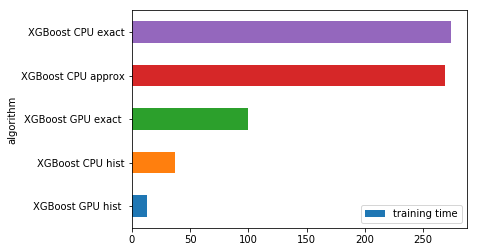

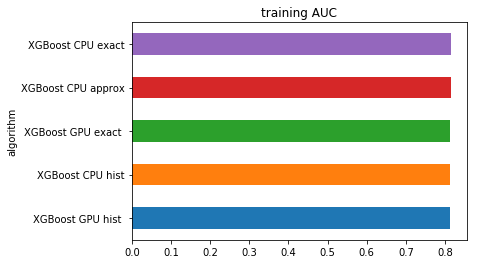

In [21]:
data.plot(label="training time",kind='barh',x='algorithm',y='training time')
data.plot(title="training AUC",kind='barh',x='algorithm',y='training AUC',legend=False)

## Now call XGBoost from H2O

In [22]:
import h2o
from h2o.estimators import H2OXGBoostEstimator
h2o.init(ip="172.17.0.2", port=54321)
path = "/data/higgs_head_2M.csv"


t_start = time.time()
df_hex = h2o.import_file(path)
print("Time to parse by H2O (sec): ", time.time() - t_start)

trainhex = df_hex
trainhex[0] = (trainhex[0]).asfactor()

Checking whether there is an H2O instance running at http://172.17.0.2:54321. connected.


H2O cluster uptime:,21 mins 41 secs
H2O cluster timezone:,Etc/UTC
H2O data parsing timezone:,UTC
H2O cluster version:,3.20.0.7
H2O cluster version age:,5 days
H2O cluster name:,root
H2O cluster total nodes:,1
H2O cluster free memory:,3.027 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"locked, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
Time to parse by H2O (sec):  4.885279417037964


In [23]:
def runH2OXGBoost(param):
    label = "H2O XGBoost " \
    + ("GPU" if "backend" in param.keys() and "gpu"==param["backend"] else "CPU") \
    + (" " + param["tree_method"] if "tree_method" in param.keys() else "")
    print(label)
    print("=====================")
    for k, v in param.items():
        print(k, v)
    print("=====================")
        
    t_start = time.time()
    model = H2OXGBoostEstimator(**param)
    model.train(x = list(range(1,trainhex.shape[1])), y = 0, training_frame = trainhex)
    tt = time.time() - t_start
    print("Time to train (sec): ", tt)
    h2o_train_times.append(tt)

    t_start = time.time()
    preds = model.predict(trainhex)[:,2]
    tt = time.time() - t_start
    print("Time to predict (sec): ", tt)
    h2o_score_times.append(tt)

    preds = h2o.as_list(preds)
    labels = train_target.values
    auc = metrics.roc_auc_score(labels, preds)
    print("Training AUC:", auc)

    h2o_valid_aucs.append(auc)
    h2o_plot_labels.append(label)
    
    #pd.DataFrame(model.varimp(),columns=["Feature","","Importance",""]).head(10).plot(label='importance',kind="barh",x="Feature",y="Importance").invert_yaxis()

In [24]:
h2o_valid_aucs = []
h2o_train_times = []
h2o_score_times = []
h2o_plot_labels = []

In [25]:
param = {
    "ntrees":num_round
    , "max_depth":max_depth
    , "eta":learn_rate
    , "subsample":0.7
    , "colsample_bytree":0.9
    , "min_child_weight":5
    , "seed":12345
    , "score_tree_interval":num_round
    , "backend":"cpu"
    , "tree_method":"exact"
}
runH2OXGBoost(param)

H2O XGBoost CPU exact
ntrees 100
max_depth 10
eta 0.02
subsample 0.7
colsample_bytree 0.9
min_child_weight 5
seed 12345
score_tree_interval 100
backend cpu
tree_method exact
xgboost Model Build progress: |███████████████████████████████████████████| 100%
Time to train (sec):  288.1534354686737
xgboost prediction progress: |████████████████████████████████████████████| 100%
Time to predict (sec):  4.503039836883545
Training AUC: 0.8201899729303845


In [26]:
param = {
    "ntrees":num_round
    , "max_depth":max_depth
    , "eta":learn_rate
    , "subsample":0.7
    , "colsample_bytree":0.9
    , "min_child_weight":5
    , "seed":12345
    , "score_tree_interval":num_round
    , "backend":"cpu"
    , "tree_method":"approx"
}
runH2OXGBoost(param)

H2O XGBoost CPU approx
ntrees 100
max_depth 10
eta 0.02
subsample 0.7
colsample_bytree 0.9
min_child_weight 5
seed 12345
score_tree_interval 100
backend cpu
tree_method approx
xgboost Model Build progress: |███████████████████████████████████████████| 100%
Time to train (sec):  165.13393354415894
xgboost prediction progress: |████████████████████████████████████████████| 100%
Time to predict (sec):  4.491177320480347
Training AUC: 0.8182765188341345


In [27]:
param = {
    "ntrees":num_round
    , "max_depth":max_depth
    , "eta":learn_rate
    , "subsample":0.7
    , "colsample_bytree":0.9
    , "min_child_weight":5
    , "seed":12345
    , "score_tree_interval":num_round
    , "backend":"cpu"
    , "tree_method":"hist"
}
runH2OXGBoost(param)

H2O XGBoost CPU hist
ntrees 100
max_depth 10
eta 0.02
subsample 0.7
colsample_bytree 0.9
min_child_weight 5
seed 12345
score_tree_interval 100
backend cpu
tree_method hist
xgboost Model Build progress: |███████████████████████████████████████████| 100%
Time to train (sec):  54.937657833099365
xgboost prediction progress: |████████████████████████████████████████████| 100%
Time to predict (sec):  4.5335564613342285
Training AUC: 0.8193356926494528


In [28]:
param = {
    "ntrees":num_round
    , "max_depth":max_depth
    , "learn_rate":learn_rate
    , "sample_rate":0.7
    , "col_sample_rate_per_tree":0.9
    , "min_rows":5
    , "seed":12345
    , "score_tree_interval":num_round
    , "backend":"gpu"
    , "tree_method":"exact"
}
runH2OXGBoost(param)

H2O XGBoost GPU exact
ntrees 100
max_depth 10
learn_rate 0.02
sample_rate 0.7
col_sample_rate_per_tree 0.9
min_rows 5
seed 12345
score_tree_interval 100
backend gpu
tree_method exact
xgboost Model Build progress: |███████████████████████████████████████████| 100%
Time to train (sec):  112.73951983451843
xgboost prediction progress: |████████████████████████████████████████████| 100%
Time to predict (sec):  4.488598346710205
Training AUC: 0.8192764465727664


In [29]:
param = {
    "ntrees":num_round
    , "max_depth":max_depth
    , "learn_rate":learn_rate
    , "sample_rate":0.7
    , "col_sample_rate_per_tree":0.9
    , "min_rows":5
    , "seed":12345
    , "score_tree_interval":num_round
    , "backend":"gpu"
    , "tree_method":"hist"
}
runH2OXGBoost(param)

H2O XGBoost GPU hist
ntrees 100
max_depth 10
learn_rate 0.02
sample_rate 0.7
col_sample_rate_per_tree 0.9
min_rows 5
seed 12345
score_tree_interval 100
backend gpu
tree_method hist
xgboost Model Build progress: |███████████████████████████████████████████| 100%
Time to train (sec):  17.992936372756958
xgboost prediction progress: |████████████████████████████████████████████| 100%
Time to predict (sec):  4.478320837020874
Training AUC: 0.819560054254743


## H2O GBM (CPU)

In [30]:
from h2o.estimators.gbm import H2OGradientBoostingEstimator
param = {
      "ntrees":num_round
    , "max_depth":max_depth
    , "learn_rate":learn_rate
    , "sample_rate":0.7
    , "col_sample_rate_per_tree":0.9
    , "min_rows":5
    , "seed":12345
    , "score_tree_interval":num_round
}

t_start = time.time()
model = H2OGradientBoostingEstimator(**param)
model.train(x = list(range(1,trainhex.shape[1])), y = 0, training_frame = trainhex)
tt = time.time() - t_start
print("Time to train (sec): ", tt)
h2o_train_times.append(tt)

t_start = time.time()
preds = model.predict(trainhex)[:,2]
tt = time.time() - t_start
print("Time to predict (sec): ", tt)
h2o_score_times.append(tt)

preds = h2o.as_list(preds)
labels = train_target.values
auc = metrics.roc_auc_score(labels, preds)
print("AUC:", auc)

h2o_valid_aucs.append(auc)
h2o_plot_labels.append("H2O GBM CPU")

gbm Model Build progress: |███████████████████████████████████████████████| 100%
Time to train (sec):  134.51643776893616
gbm prediction progress: |████████████████████████████████████████████████| 100%
Time to predict (sec):  10.75105357170105
AUC: 0.8183965068555489


In [31]:
data = pd.DataFrame({'algorithm'  :h2o_plot_labels,
                     'training time':h2o_train_times,
                     'scoring time':h2o_score_times,
                     'training AUC' :h2o_valid_aucs}).sort_values(by="training time")
data

,algorithm,training time,scoring time,training AUC
4,H2O XGBoost GPU hist,17.992936,4.478321,0.819560
2,H2O XGBoost CPU hist,54.937658,4.533556,0.819336
3,H2O XGBoost GPU exact,112.739520,4.488598,0.819276
5,H2O GBM CPU,134.516438,10.751054,0.818397
1,H2O XGBoost CPU approx,165.133934,4.491177,0.818277
0,H2O XGBoost CPU exact,288.153435,4.503040,0.820190


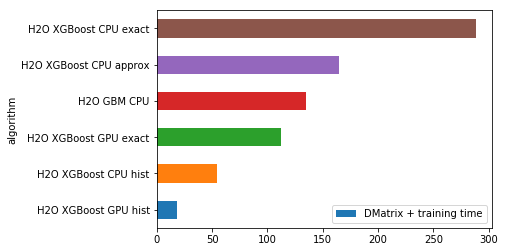

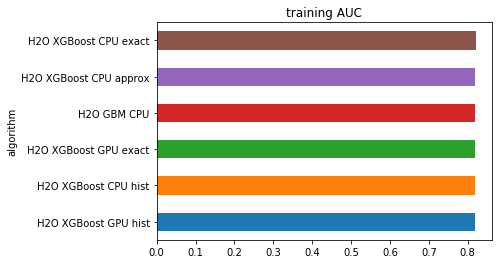

In [32]:
data.plot(label="DMatrix + training time",kind='barh',x='algorithm',y='training time')
data.plot(title="training AUC",kind='barh',x='algorithm',y='training AUC',legend=False)

### Summary: Fastest GPU algorithm (XGBoost histogram) takes 5s, fastest CPU algorithm (H2O) takes 50s

##### Note: H2O's XGBoost integration has some internal overhead still (DMatrix creation is single-threaded, and some parameters have different default values, hence the slightly slower training speed and slightly higher training accuracy) - this doesn't affect the summary conclusion